# Treść zadania

Wytrenować sieć GAN do generowania obrazów  w oparciu o 300 obrazów Moneta.

Dane są dostępne:
https://github.com/mmazurek-wat/nlp-resources-edu/raw/766a96b891da7b0d4c00b56df2085fd673c4c451/monet_jpg.zip


In [99]:
#########################
### Preparation phase ###
#########################

### Get torch library

import torch
from torch import nn, optim

from torch.utils import data

### Get other important libraries

import math
import numpy as np
import os
import requests
import zipfile

import matplotlib.pyplot as plt
from torchvision import transforms, utils as tvutils
from PIL import Image

### Get images content

url = "https://github.com/mmazurek-wat/nlp-resources-edu/raw/766a96b891da7b0d4c00b56df2085fd673c4c451/monet_jpg.zip"
zip_path = "/content/monet_jpg.zip"
images_dir = "/content/monet_jpg"

# Download zip folder
response = requests.get(url)
with open(zip_path, "wb") as file:
    file.write(response.content)
print(f"Zip saved in: {zip_path}")

# Unzip folder
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(images_dir)
print(f"Images extracted in: {images_dir}")

# Get images file_names
image_folders = [os.path.join(images_dir, file_name) for file_name in os.listdir(images_dir)]
print(f"Images count: {len(image_folders)}, images: {image_folders}")

# Check content folder
for i, (root, dirs, files) in enumerate(os.walk(images_dir)):
    print(f"{i + 1}. Files from: {root}, files_count: {len(files)}, folders: {dirs}")
    print(", ".join([file for file in files]))

Zip saved in: /content/monet_jpg.zip
Images extracted in: /content/monet_jpg
Images count: 300, images: ['/content/monet_jpg/661e374153.jpg', '/content/monet_jpg/b99546090b.jpg', '/content/monet_jpg/bc4b364a44.jpg', '/content/monet_jpg/50855dd324.jpg', '/content/monet_jpg/2759c1ed37.jpg', '/content/monet_jpg/d754850d01.jpg', '/content/monet_jpg/32cc820303.jpg', '/content/monet_jpg/c4622e3fb6.jpg', '/content/monet_jpg/8b841420b4.jpg', '/content/monet_jpg/51bdd25f76.jpg', '/content/monet_jpg/417e77e946.jpg', '/content/monet_jpg/8c48e112d0.jpg', '/content/monet_jpg/4c74254ad3.jpg', '/content/monet_jpg/b13c0973ee.jpg', '/content/monet_jpg/064487d630.jpg', '/content/monet_jpg/1a127acf4d.jpg', '/content/monet_jpg/2cca56415e.jpg', '/content/monet_jpg/4260d1c556.jpg', '/content/monet_jpg/e9f5563817.jpg', '/content/monet_jpg/608ee0d370.jpg', '/content/monet_jpg/16dabe418c.jpg', '/content/monet_jpg/732d76a469.jpg', '/content/monet_jpg/99a51d3e25.jpg', '/content/monet_jpg/e753318d04.jpg', '/conte

In [100]:
##########################
### Configuratin phase ###
##########################

### Set seed for the same random results
torch.manual_seed(999)

### Use deterministic algorithms to have the same result each run
torch.use_deterministic_algorithms(True)

### Choose the proper devide
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

### TODO:
#     Custom weights initialization function?

### Configuration parameters - to mess with to improve training phase results

# Data preparation phase
batch_size = 32             # Amount of probes per batch
shuffle_data = True         # Will data for DataLoader be shuffled?
num_workers = 2             # Amount of threads to process the data for DataLoader

# Models declaration phase
z_dim = 100                 # Dimension of the latent space
img_channels = 3            # Number of channels in the output image (3 for RGB)
feature_g = 64              # Number of generator feature maps
feature_d = 64              # Number of discriminator feature maps

# Training parameters
learning_rate = lr = 0.0002 # Learning rate
beta1 = 0.9                 # Percantage of previous gradients in momentum (Adam oprtimizer)
epochs = 200                # Number of training epochs
img_size = 64               # Images size (img_size x img_size)

32


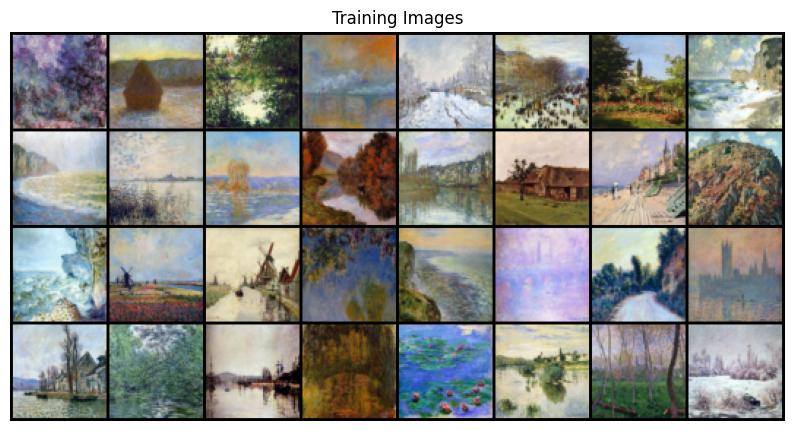

In [101]:
##############################
### Data preparation phase ###
##############################

# MonetDataset Class to Load Images to DataLoader
class MonetDataset(data.Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

# Transformations
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),  # Resize to img_size x img_size
    transforms.ToTensor(),  # Convert to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Create Dataset and DataLoader
dataset = MonetDataset(image_folders, transform=transform)
dataloader = data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle_data, num_workers=num_workers)

# Plot some training images
real_batch = next(iter(dataloader))
print(len(real_batch))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(tvutils.make_grid(real_batch[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()

In [102]:
################################
### Models declaration phase ###
################################

### Creating Generator

class Generator(nn.Module):
    def __init__(self, z_dim, img_channels, feature_g):
        super(Generator, self).__init__()
        self.model = nn.Sequential(

            # Input: Latent vector z_dim

            # Layer 1: Latent z_dim to feature_g * 8 channels
            nn.ConvTranspose2d(z_dim, feature_g * 8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(feature_g * 8),
            nn.ReLU(True),
            # Output: (feature_g * 8) x 4 x 4

            # Layer 2: Up-sample and apply BatchNorm
            nn.ConvTranspose2d(feature_g * 8, feature_g * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_g * 4),
            nn.ReLU(True),
            # Output: (feature_g * 4) x 8 x 8

            # Layer 3: Up-sample again
            nn.ConvTranspose2d(feature_g * 4, feature_g * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_g * 2),
            nn.ReLU(True),
            # Output: (feature_g * 2) x 16 x 16

            # Layer 4: Final up-sample to the desired image size
            nn.ConvTranspose2d(feature_g * 2, feature_g * 1, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_g),
            nn.ReLU(True),
            # Output: (feature_g) x 32 x 32

            # Layer 5: Final up-sample to the desired image size
            nn.ConvTranspose2d(feature_g, img_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # Output: img_channels x 64 x 64
        )

    def forward(self, x):
        return self.model(x)

### Creating Discriminator

class Discriminator(nn.Module):
    def __init__(self, img_channels, feature_d):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(

            # Input: img_channels x 64 x 64

            # Layer 1: Input layer to feature_d * 2 channels
            nn.Conv2d(img_channels, feature_d * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # Output: (feature_d * 2) x 32 x 32

            # Layer 2: Down-sample with BatchNorm
            nn.Conv2d(feature_d * 2, feature_d * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_d * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # Output: (feature_d * 4) x 16 x 16

            # Layer 3: Further down-sample
            nn.Conv2d(feature_d * 4, feature_d * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_d * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # Output: (feature_d * 8) x 8 x 8

            # Layer 4: Further down-sample
            nn.Conv2d(feature_d * 8, feature_d * 16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_d * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # Output: (feature_d * 16) x 4 x 4

            # Final layer: Output 1 x 1 x 1 for binary classification
            nn.Conv2d(feature_d * 16, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
            # Output: 1 x 1 x 1
        )

    def forward(self, x):
        return self.model(x)

In [103]:
##################################
### Training preparation phase ###
##################################

##### Create models

netG = Generator(z_dim, img_channels, feature_g).to(device=device)
netD = Discriminator(img_channels, feature_d).to(device=device)

# Print summary of models
print("Generator:")
print(netG)
print("\nDiscriminator:")
print(netD)

### Create loss computation function based on BCE - Binary Cross Entropy
criterion = nn.BCELoss()

### Create optimizers
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))

### Create noise for progress wisualization
fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)

### Create lists to track learning loss over the iterations
generator_loss, discriminator_loss = [], []
iters = 0

Generator:
Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): T

In [104]:
######################
### Training phase ###
######################

for epoch in range(epochs):
    for i, real_images in enumerate(dataloader):

        # -------------------------- #
        # Training the Discriminator #
        # -------------------------- #

        # Train on real pictures
        netD.zero_grad()
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        label = torch.full((batch_size,), 1.0, dtype=torch.float, device=device) # Real labels (1.0)
        output = netD(real_images).view(-1)
        lossD_real = criterion(output, label)
        lossD_real.backward()

        # Train on fake pictures
        noise = torch.randn(batch_size, z_dim, 1, 1, device=device)  # Random noise
        fake_images = netG(noise)  # Images from generator
        label.fill_(0.0)  # Fake labels (0.0)
        output = netD(fake_images.detach()).view(-1)
        lossD_fake = criterion(output, label)
        lossD_fake.backward()

        lossD = lossD_real + lossD_fake  # Total discriminator loss
        optimizerD.step()

        # ---------------------- #
        # Training the Generator #
        # ---------------------- #

        netG.zero_grad()
        label.fill_(1.0)  # Real labels (1.0) - set fake images as real
        output = netD(fake_images).view(-1)
        lossG = criterion(output, label)
        lossG.backward()
        optimizerG.step()

        # Display progress every 50 batches
        if i % 50 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] | LossD: {lossD.item():.4f} | LossG: {lossG.item():.4f}")

        # Save Losses for plotting later
        discriminator_loss.append(lossD.item())
        generator_loss.append(lossG.item())

    # Progress visualization
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    tvutils.save_image(fake, f"output_epoch_{epoch+1}.png", normalize=True)

print("Training completed")

Epoch [1/200] | LossD: 1.4587 | LossG: 9.5590
Epoch [2/200] | LossD: 0.1377 | LossG: 15.7386
Epoch [3/200] | LossD: 0.0383 | LossG: 13.5899
Epoch [4/200] | LossD: 0.1367 | LossG: 23.7091
Epoch [5/200] | LossD: 0.0087 | LossG: 24.3960
Epoch [6/200] | LossD: 0.0016 | LossG: 10.1016
Epoch [7/200] | LossD: 0.0786 | LossG: 22.7240
Epoch [8/200] | LossD: 0.6804 | LossG: 8.4904
Epoch [9/200] | LossD: 0.0608 | LossG: 18.1233
Epoch [10/200] | LossD: 0.6151 | LossG: 14.1384
Epoch [11/200] | LossD: 0.0211 | LossG: 20.8504
Epoch [12/200] | LossD: 0.0053 | LossG: 10.9577
Epoch [13/200] | LossD: 0.0242 | LossG: 9.9105
Epoch [14/200] | LossD: 0.0116 | LossG: 8.2625
Epoch [15/200] | LossD: 0.0168 | LossG: 10.4468
Epoch [16/200] | LossD: 0.0077 | LossG: 9.5811
Epoch [17/200] | LossD: 0.0233 | LossG: 10.3826
Epoch [18/200] | LossD: 0.0932 | LossG: 8.8377
Epoch [19/200] | LossD: 0.0165 | LossG: 8.9161
Epoch [20/200] | LossD: 0.0069 | LossG: 8.7079
Epoch [21/200] | LossD: 0.0210 | LossG: 6.9161
Epoch [22/

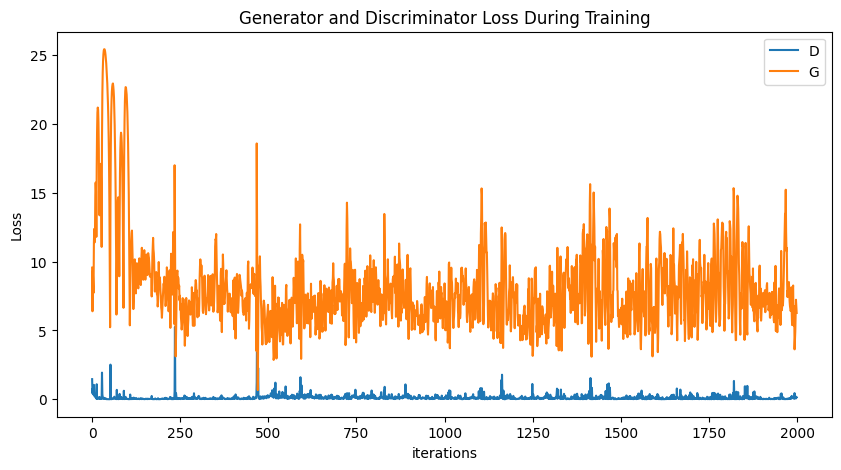

In [105]:
# Show training loss over the epochs
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(discriminator_loss,label="D")
plt.plot(generator_loss,label="G")
plt.xlabel("iterations")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

32


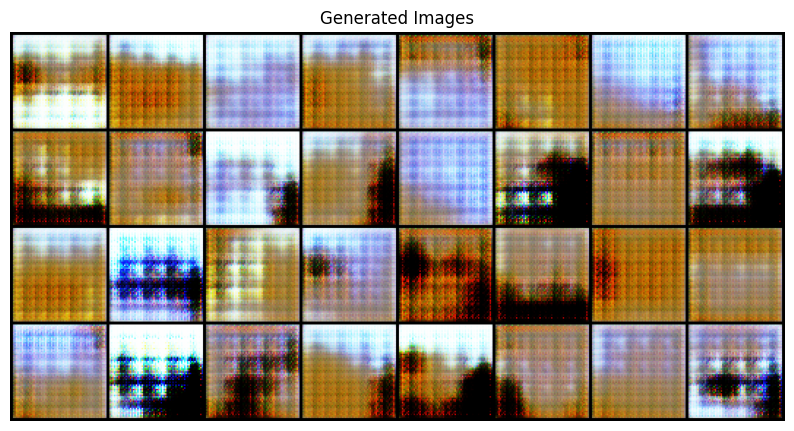

In [106]:
num_images = len(real_batch)
print(num_images)

# Generate images using the generator
with torch.no_grad():
    latent_vectors = torch.randn(num_images, z_dim, 1, 1, device=device)
    generated_images = netG(latent_vectors).detach().cpu()

# Plot some generated images
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(tvutils.make_grid(generated_images, padding=2, normalize=True), (1, 2, 0)))
plt.show()

Resultat dla 50 epok:

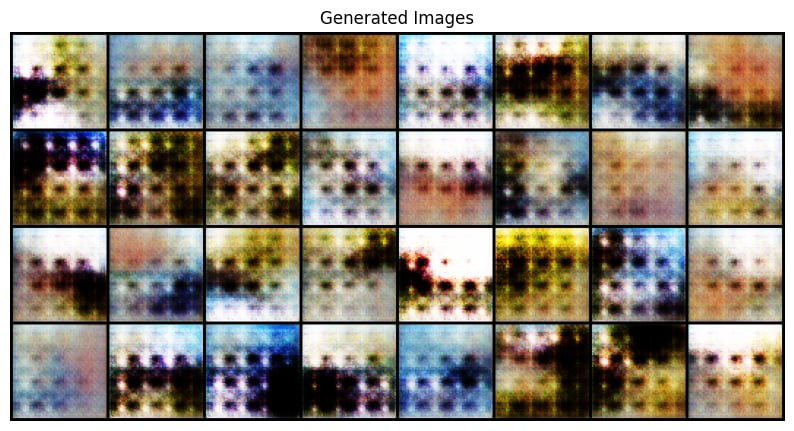